# Step 1 : importing Essential Libraries


These libraries collectively provide functionality for data preparation, model building, training, evaluation, and visualization for a deep learning task.

In [12]:
import os

# Set the maximum number of images to display
max_images = 5

# Specify the input directory path
input_directory = '/kaggle/input'

# List and print the filenames of a limited number of images
count = 0
for dirname, _, filenames in os.walk(input_directory):
    for filename in filenames:
        if count < max_images and filename.endswith(('.jpg', '.png', '.jpeg')):
            print(os.path.join(dirname, filename))
            count += 1

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [14]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Step 2 : Making Dictionary of images and labels
In this step I have made the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part1.zip and HAM10000_images_part2.zip

In [15]:
base_skin_dir = os.path.join('..', '/Users/deekshithkandregula/Downloads/Skin cancer')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Step 3 : Reading & Processing data
In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir. After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [16]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [17]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2


# Step 4 : Data Cleaning
In this step we check for Missing values and datatype of each field

In [18]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [19]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

/var/folders/8m/wnjwg0rs74g36dj27lwhh0vr0000gn/T/ipykernel_20022/3479505362.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


Now, lets check the presence of null values again

In [20]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [21]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


# Step 5 : EDA
In this we will explore different features of the dataset , their distrubtions and actual counts

Plot to see distribution of 7 different classes of cell type

<Axes: xlabel='cell_type'>

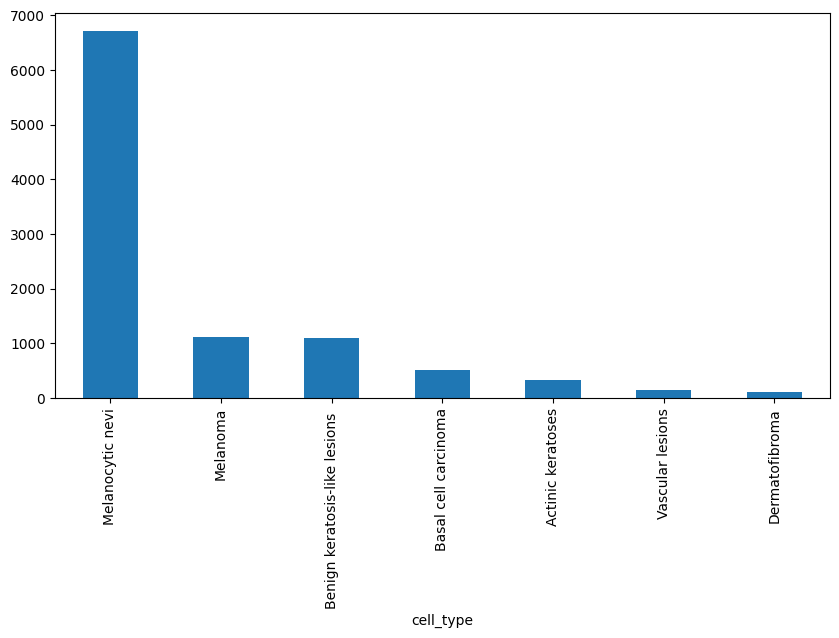

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

Plotting of Technical Validation field (ground truth) which is dx_type to see the distribution of its 4 categories which are listed below :
1. Histopathology(Histo): Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: xlabel='dx_type'>

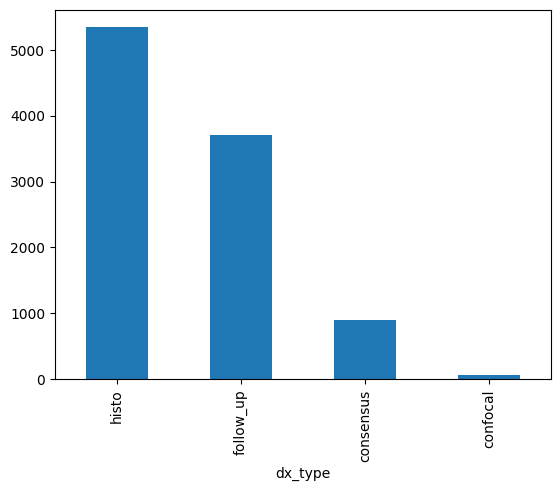

In [23]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

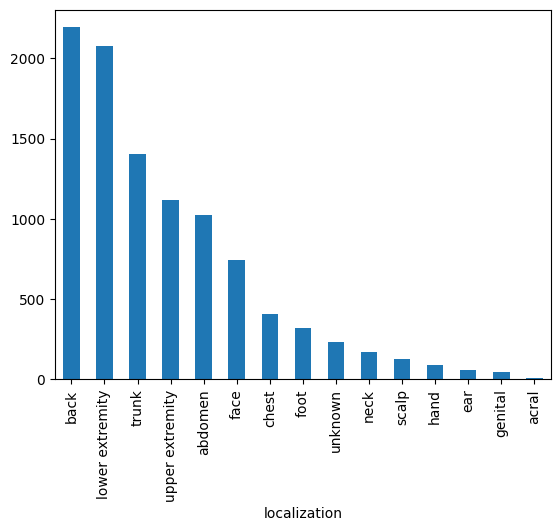

In [24]:
skin_df['localization'].value_counts().plot(kind='bar')

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

Now, check the distribution of Age

<Axes: >

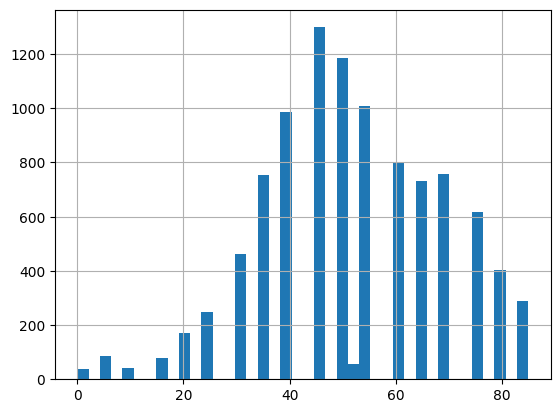

In [25]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

Lets see the distribution of males and females

<Axes: xlabel='sex'>

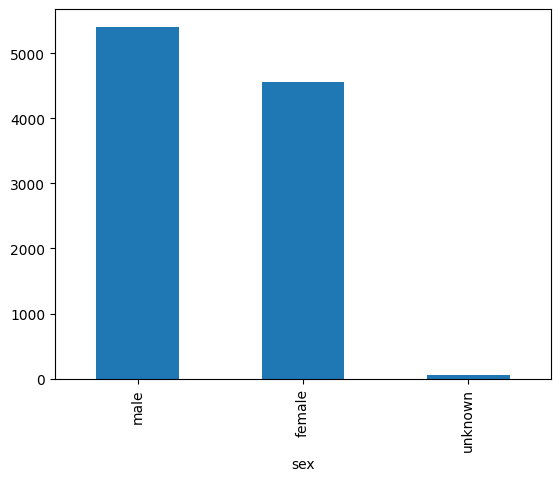

In [26]:
skin_df['sex'].value_counts().plot(kind='bar')

<Axes: xlabel='age', ylabel='cell_type_idx'>

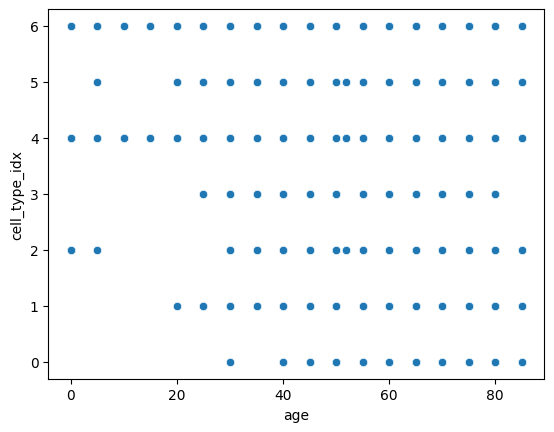

In [27]:
sns.scatterplot(x='age', y='cell_type_idx', data=skin_df)


It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

Sexwise distribution of skin cancer type

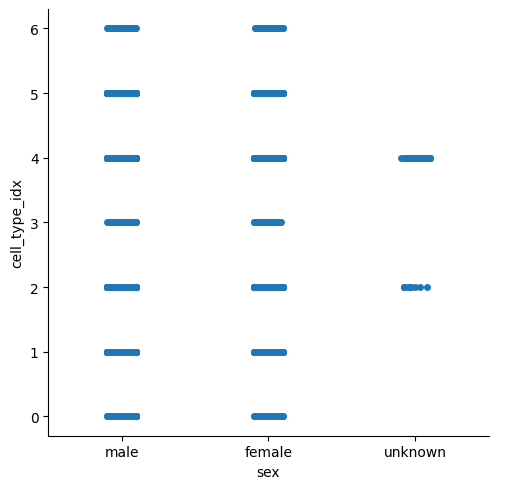

In [28]:
sns.catplot(x='sex', y='cell_type_idx', data=skin_df)


# Step 6: Loading and resizing of images
In this step images will be loaded into the column named image from the image path from the image folder. We also resize the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75. As this step resize all the 10015 images dimensions into 100x 75 so be patient it will take some time.

In [29]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [30]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/deekshithkandregula/Downloads/Skin canc...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


As we can see image column has been added in its color format code

Most interesting part its always better to see sample of images Below we will show images of each cancer type

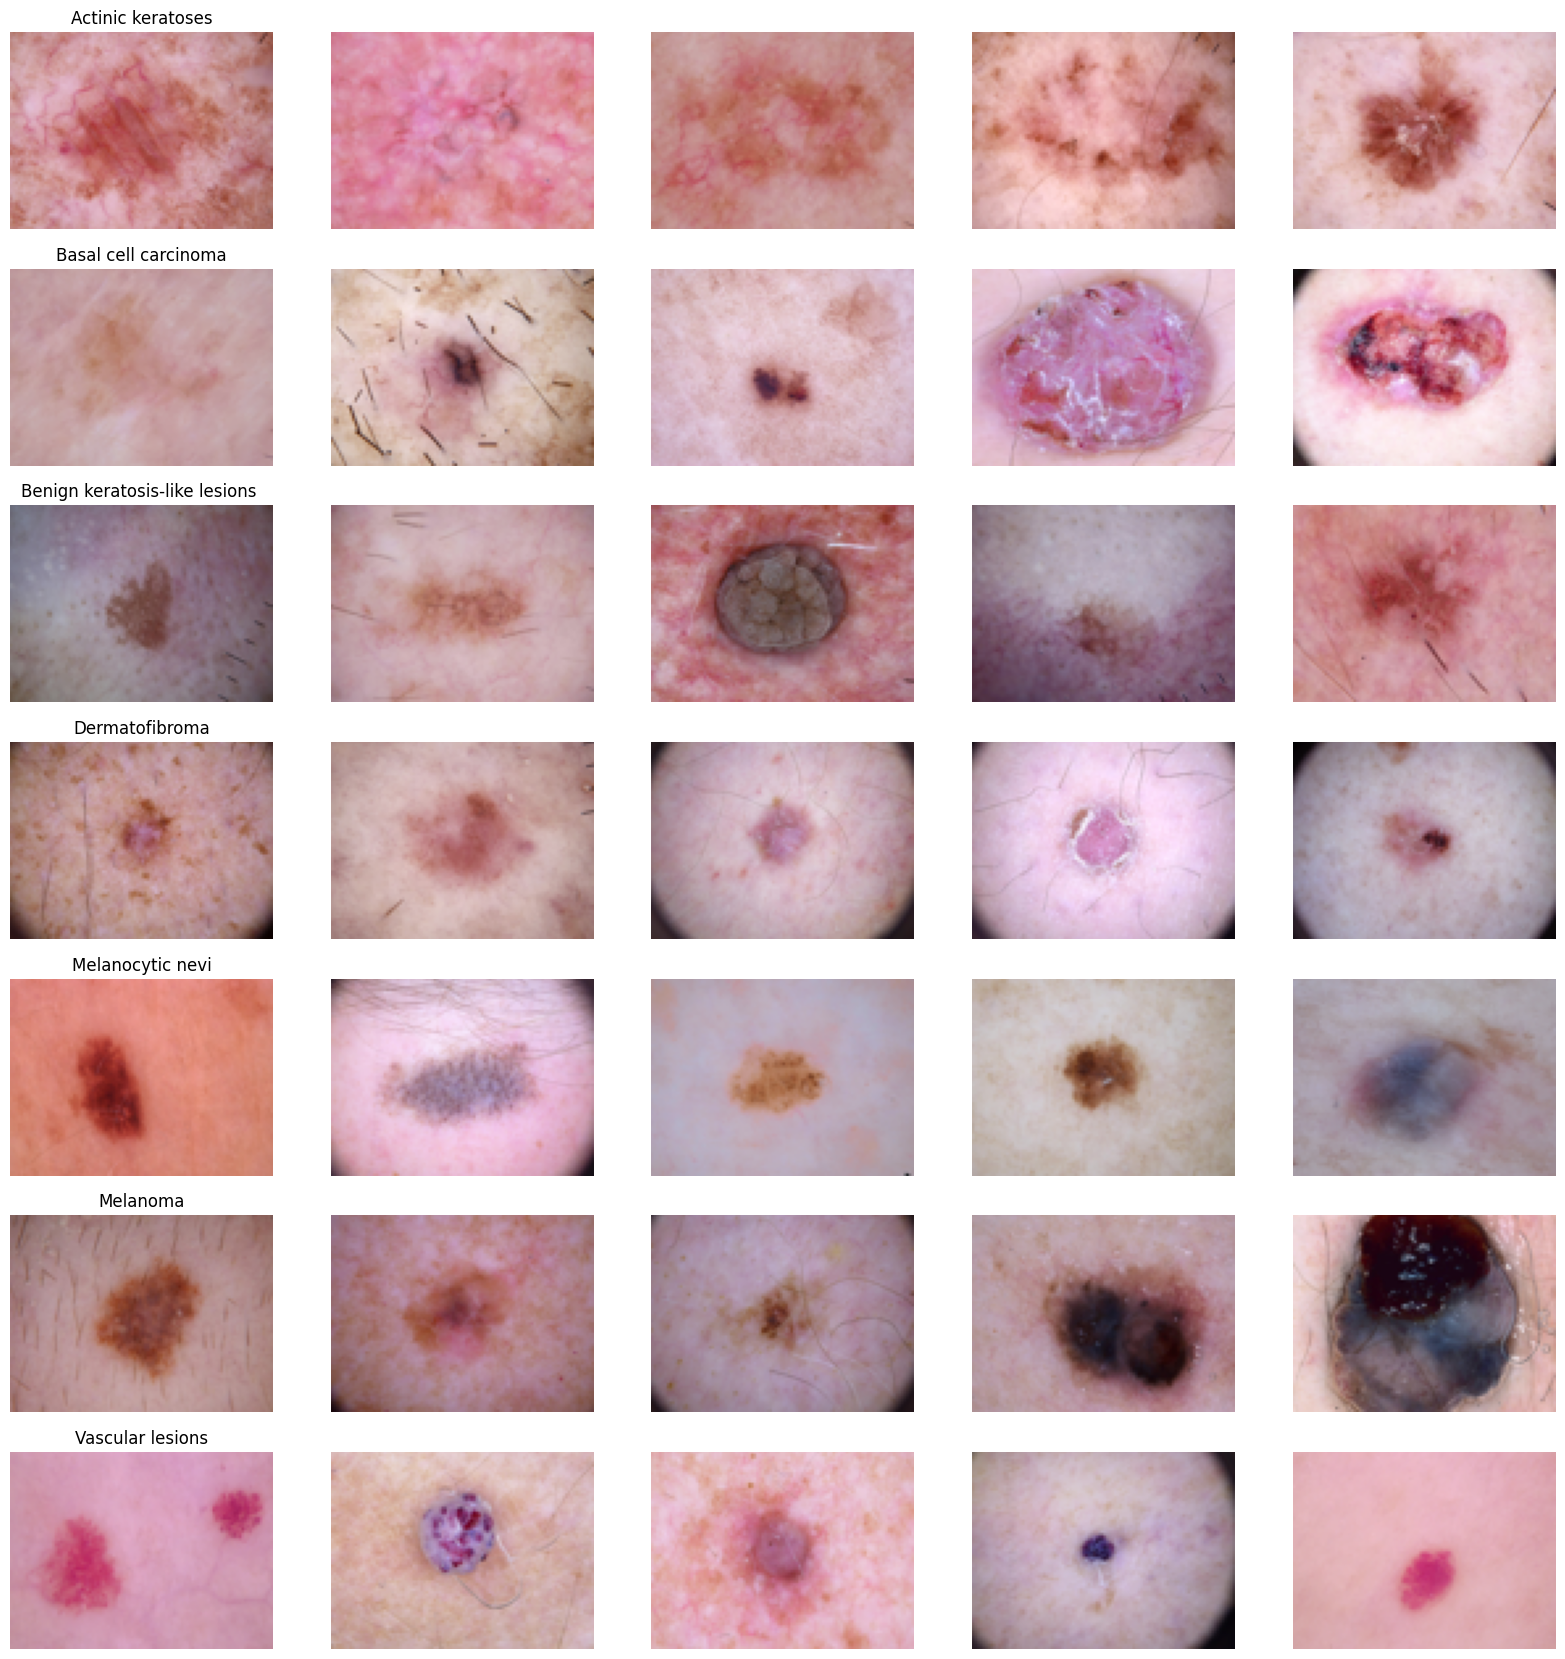

In [31]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [32]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

In [33]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Step 7 : Train Test Split
In this step we have splitted the dataset into training and testing set of 80:20 ratio

In [34]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Step 8 : Normalization
I choosed to normalize the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.

In [35]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 9 : Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [36]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Step 10 : Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [37]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [38]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# #Step 11: Model Building

CNN
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.


In [39]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

# Step 12: Setting Optimizer and Annealer


In [41]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    decay=0.0,
    amsgrad=False
)



In [42]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [43]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Data Augmentation


In [44]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

For the data augmentation, i choosed to : Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset .

# Step 13: Fitting the model
In this step finally I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train

In [54]:
epochs = 50
batch_size = 10

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.5
    return lr

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

try:
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_validate, y_validate),
        verbose=1,
        steps_per_epoch=x_train.shape[0] // batch_size,
        callbacks=[LearningRateScheduler(lr_schedule)]
    )
except Exception as e:
    print(f"An error occurred during training: {e}")
    raise  # Reraise the exception to see the full traceback


Epoch 1/5
721/721 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.6760 - loss: 0.9111 - val_accuracy: 0.7082 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 2/5


2024-03-09 14:21:55.632323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7082 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 3/5
721/721 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.6952 - loss: 0.8492 - val_accuracy: 0.7207 - val_loss: 0.8269 - learning_rate: 0.0010
Epoch 4/5


2024-03-09 14:22:58.271056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7207 - val_loss: 0.8269 - learning_rate: 0.0010
Epoch 5/5
721/721 ━━━━━━━━━━━━━━━━━━━━ 69s 96ms/step - accuracy: 0.6937 - loss: 0.8418 - val_accuracy: 0.7095 - val_loss: 0.8139 - learning_rate: 0.0010


# Step 14: Model Evaluation¶
In this step we will check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [55]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7049 - loss: 0.7984
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7362 - loss: 0.7539


Validation: accuracy = 0.709476  ;  loss_v = 0.813949
Test: accuracy = 0.695956  ;  loss = 0.805002


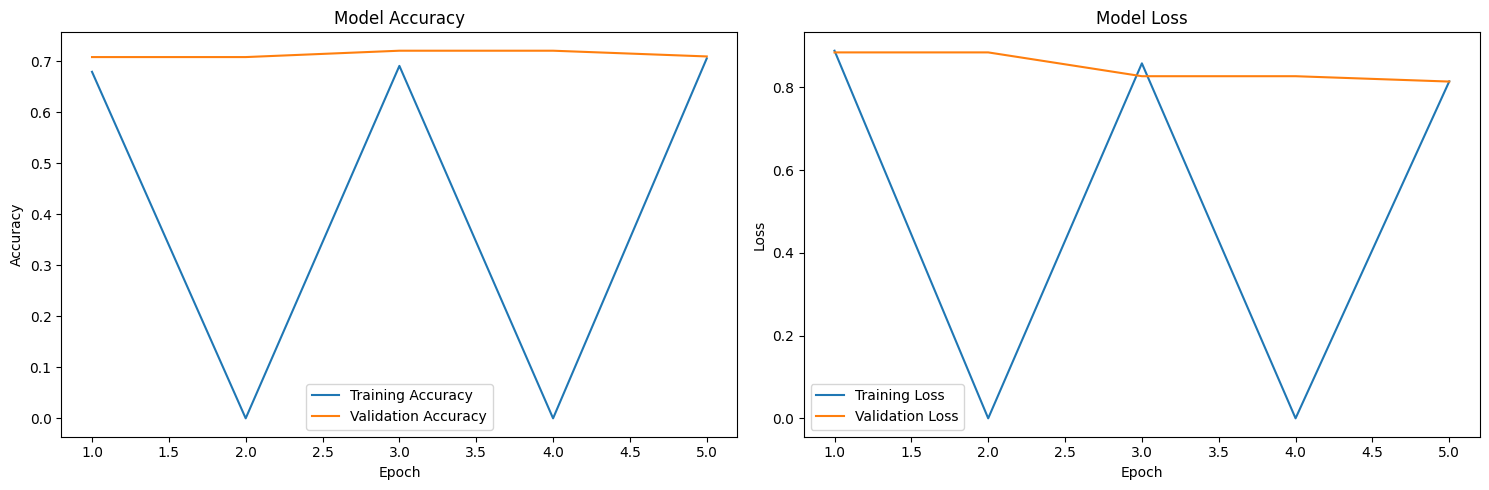

In [56]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training and validation accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot training and validation loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'], label='Training Loss')
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Assuming history is the training history of your model
plot_model_history(history)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


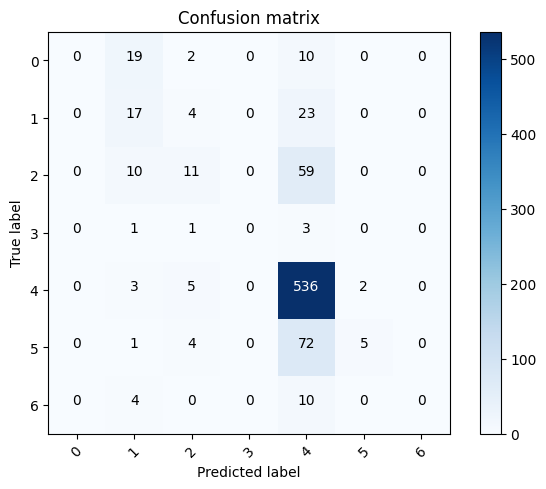

In [57]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Now, lets which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

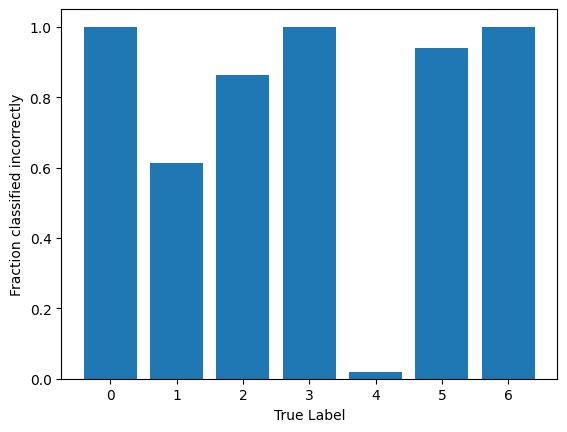

In [58]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')